In [1]:
import os
import time
import calendar
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
dir_path = os.getcwd()
script_dir = os.path.join(os.getcwd(),'atnresilience','')
os.chdir(script_dir)

import db_tools
import atn_analysis
import atn_visualization
import create_atn_db
import atn_tools

matplotlib.style.use('classic')
plt.rcParams["font.family"] = "Times New Roman" #Set font type for all plots
sns.set_palette("colorblind") #set color scheme for all plots
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('legend',labelspacing=0.15,fontsize=10,edgecolor='0.8')
line_type = {1:'-',2:'--',3:':',4:'-.'} 

graph_direc = '%s/data/graph/'%(dir_path,)
processed_direc = '%s/data/processed/'%(dir_path,)
db_path = '%s/data/processed/atn_db.sqlite' %(dir_path,)

In [2]:
airline_list = ['AA','DL','UA','WN']
# airline_list = ['ALL','AA','DL','UA','WN']
year_start = 2015
year_end = 2017
include_data = 'ADM'
year_range =  list(range(year_start, year_end+1))

In [3]:
for airline in airline_list:
    for year in year_range:
        edge_weight_df = atn_tools.weighted_edge(db_path, year, airline)
        edge_weight_df.to_csv('%s%s_%s_edge_weights.csv'%(processed_direc,airline,year))

KeyboardInterrupt: 

### Histogram of Dropped Airports
Get list of airports kept or dropped in each network based on the airline and year list. Each data point is an airport in the network, meaning an airport will appear multiple times in multiple networks (each unique airline + year combination) <br>

Set get_dropped to False to plot the airports kept. <br>
Set get_dropped to True to plot the airports dropped.

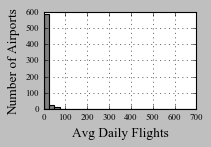

In [12]:
get_dropped = True

stats_df = pd.DataFrame(columns=['Destination_Airport_Code','FlightCount','ValidDays'])

filter_type = '<' if get_dropped else '='

for airline in airline_list:
    for year in year_range:
        airline_sql = '''
            SELECT Destination_Airport_Code,
            COUNT(*)/:days_in_year AS FlightCount,
            COUNT(DISTINCT(Day_Of_Year)) AS ValidDays
            FROM atn_performance
            WHERE Year = :year
            AND Unique_Carrier_ID LIKE :airline
            AND Can_Status != 1 AND Div_Status != 1 
            GROUP BY Destination_Airport_Code
            HAVING COUNT(DISTINCT(Day_Of_Year)) %s :days_in_year
            ''' %(filter_type)

        no_of_days = 366 if calendar.isleap(year) == 1 else 365

        params={'year' : year, 'days_in_year' : no_of_days, 'airline' : airline}
        stats_df = stats_df.append(db_tools.DBQueries().query_to_df(airline_sql, params=params), ignore_index=True)

stats_df = stats_df.astype({'FlightCount':'int64','ValidDays':'int64'})

title_name = 'dropped_airports' if get_dropped else 'filtered_airports'
bins = np.linspace(0,700,29)
pd.DataFrame.hist(data=stats_df,column='FlightCount', color='gray', bins=bins, figsize=(2.8,2.0))
plt.ylim(top=600)
plt.title('')
plt.xlabel('Avg Daily Flights')
plt.ylabel('Number of Airports')

plt.tight_layout()

save_path = graph_direc + title_name.lower().replace(' ','_' ) + '.pdf'
plt.savefig(save_path, dpi=300, transparent=True)

### Create the airline Z-score of the daily airline mean. 
Z-score is calculated for the daily mean of each airline where the daily mean is the mean of all filtered airports in an airline's network in a given day.

In [4]:
for airline in airline_list:
    for year in year_range:
        airline_df = atn_analysis.airline_z_score(year,airline,processed_direc)

2015 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/ALL_2015_airline_Zdata_ADM.csv
2016 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/ALL_2016_airline_Zdata_ADM.csv
2017 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/ALL_2017_airline_Zdata_ADM.csv
2015 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/AA_2015_airline_Zdata_ADM.csv
2016 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/AA_2016_airline_Zdata_ADM.csv
2017 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/AA_2017_airline_Zdata_ADM.csv
2015 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/DL_2015_airline_Zdata_ADM.csv
2016 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/DL_2016_airline_Zdata_ADM.csv
2017 Z-score file created at /Users/allen/Documents/atnresilience/data/processed/DL_2017_airline_Zdata_ADM.cs

### Create the rolling mean plot of the airline Z-score.

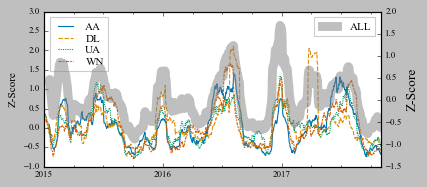

In [3]:
atn_visualization.rolling_mean_plot(year_range,airline_list, 'ADM', processed_direc, 'airline_z',y_upper=3)

plt.savefig('%sairline_zscore_rolling_mean.pdf' %(graph_direc,), dpi = 300,transparent=True)

### Create and load data for FAA N-number registry and aircraft type data


The FAA data can be obtained from:
https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download/ 

The files MASTER.txt, ACTREF.txt, and DEREG.txt must be in the data/raw/ folder.


In [3]:
# Create the database tables
ac_data_loader = create_atn_db.ACDataLoader()
ac_data_loader.create_registry_table()
ac_data_loader.create_dereg_table()
ac_data_loader.create_ac_ref_table()

In [3]:
# Load the data
ac_data_loader.import_current_nnum_data()
ac_data_loader.import_dereg_nnum_data()
ac_data_loader.import_acref_data()

In [ ]:
get_dropped = False

stats_df = pd.DataFrame(columns=['Destination_Airport_Code','FlightCount','ValidDays'])

filter_type = '<' if get_dropped else '='

for airline in airline_list:
    for year in year_range:
        airline_sql = '''
            SELECT atn.Year, atn.Day_Of_Year, atn.Unique_Carrier_id, 
                atn.Tail_Number, atn.airline_ID, atn.Origin_Airport_Code, 
                atn.Destination_Airport_Code, nnum.MFR_CODE, ac.CODE
            FROM atn_performance atn
            LEFT JOIN nnum_master nnum
                ON nnum.N_NUMBER = 'N' +  atn.Tail_Number
            LEFT JOIN ac_ref ac
                ON ac.CODE = nnum.MFR_CODE
            WHERE Year = :year
            AND Unique_Carrier_ID LIKE :airline
            AND Can_Status != 1 AND Div_Status != 1 
            HAVING COUNT(DISTINCT(Day_Of_Year)) %s :days_in_year
            ''' %(filter_type)

        no_of_days = 366 if calendar.isleap(year) == 1 else 365

        params={'year' : year, 'days_in_year' : no_of_days, 'airline' : airline}
        stats_df = stats_df.append(db_tools.DBQueries().query_to_df(airline_sql, params=params), ignore_index=True)

### Get cancellation distribution plot

Plot the daily flight cancellation across all airline within the timeframe analyzed (2015-2017)

In [35]:
# Import the cancellation data
sql = '''
SELECT FLIGHT_DATE, COUNT(*) AS TOTAL_FLIGHTS, SUM(CAN_STATUS) AS CANCEL_COUNT
FROM atn_performance
WHERE YEAR >= 2015
and YEAR <= 2017
GROUP BY FLIGHT_DATE
'''

cancel_df = db_tools.DBQueries().query_to_df(sql)
cancel_df['CAN_PCT'] = 100*cancel_df['CANCEL_COUNT']/cancel_df['TOTAL_FLIGHTS']

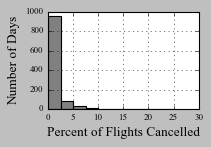

In [36]:
cancel_df.hist(column='CAN_PCT',color='gray',figsize=(2.8,2.0))
plt.title('')

plt.ylim(top=1000)

plt.xlabel('Percent of Flights Cancelled')
plt.ylabel('Number of Days')

filepath = graph_direc + 'cancellation_distribution.pdf'
plt.tight_layout()

plt.savefig(filepath, dpi=300,transparent=True)

In [29]:
year_list = [2015, 2016, 2017]

main_df = pd.DataFrame(columns=['FLIGHT_DATE','TOTAL_FLIGHTS','CANCEL_COUNT'])
for year in year_list:
    days_in_year = 366 if calendar.isleap(year) == 1 else 365
    sql = '''            
    SELECT FLIGHT_DATE, COUNT(*) AS TOTAL_FLIGHTS, SUM(CAN_STATUS) AS CANCEL_COUNT
    FROM atn_performance
    WHERE Destination_Airport_Code IN (
        SELECT Destination_Airport_Code
        FROM atn_performance
        WHERE YEAR = :year
        AND Can_Status != 1 AND Div_Status != 1 
        GROUP BY Destination_Airport_Code
        HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
    )
    AND YEAR = :year
    AND Can_Status != 1 AND Div_Status != 1 
    GROUP BY FLIGHT_DATE
    '''
    params = {'days_in_year':days_in_year,'year':year}
    df_in = db_tools.DBQueries().query_to_df(sql,params=params)
    #print(df_in)
    main_df = main_df.append(df_in,ignore_index=True)


### Get Percentage of BTS Data Aircraft Tailnumbers Not in FAA Registry

In [3]:
for airline in airline_list:
        airline = '%' if airline == 'ALL' else airline
        for year in year_range:
                sql = '''            
                        SELECT atn.Tail_Number, MASTER.N_NUMBER as Current_Tail, DEREG.N_NUMBER as Dereg_Tail
                        FROM atn_performance atn
                        LEFT JOIN nnum_master MASTER
                                ON ATN.TAIL_NUMBER = MASTER.N_NUMBER
                        LEFT JOIN nnum_dereg DEREG
                                ON ATN.TAIL_NUMBER = DEREG.N_NUMBER
                        WHERE atn.Destination_Airport_Code IN (
                                SELECT Destination_Airport_Code
                                FROM atn_performance
                                WHERE Year = :year
                                AND Unique_Carrier_ID LIKE :airline
                                AND Can_Status != 1 
                                AND Div_Status != 1 
                                GROUP BY Destination_Airport_Code
                                HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
                                )
                        AND atn.Year = :year
                        AND atn.Unique_Carrier_ID LIKE :airline
                        AND atn.Can_Status != 1 AND atn.Div_Status != 1 
                        '''

                no_of_days = 366 if calendar.isleap(year) == 1 else 365

                params={'year' : year, 'days_in_year' : no_of_days, 'airline' : airline}
                tailnum_df = db_tools.DBQueries().query_to_df(sql, params=params)
                missing_mask = ((pd.isna(tailnum_df['Current_Tail'])) & (pd.isna(tailnum_df['Dereg_Tail'])))
                print(airline,year,'Missing: ',sum(missing_mask),' Total: ',len(tailnum_df),' Percent Missing: ',sum(missing_mask)/len(tailnum_df))

% 2015 Missing:  625323  Total:  5564584  Percent Missing:  0.112375516300949
% 2016 Missing:  340743  Total:  4739283  Percent Missing:  0.07189758450803634
% 2017 Missing:  341769  Total:  4783329  Percent Missing:  0.0714500298850445
AA 2015 Missing:  322578  Total:  615416  Percent Missing:  0.5241625177115967
AA 2016 Missing:  306687  Total:  601167  Percent Missing:  0.510152752895618
AA 2017 Missing:  287612  Total:  669444  Percent Missing:  0.4296281690477471
DL 2015 Missing:  9  Total:  837910  Percent Missing:  1.0741010371042235e-05
DL 2016 Missing:  0  Total:  767291  Percent Missing:  0.0
DL 2017 Missing:  0  Total:  782147  Percent Missing:  0.0
UA 2015 Missing:  90  Total:  463642  Percent Missing:  0.00019411528722592
UA 2016 Missing:  0  Total:  387468  Percent Missing:  0.0
UA 2017 Missing:  0  Total:  450209  Percent Missing:  0.0
WN 2015 Missing:  1196  Total:  1056925  Percent Missing:  0.0011315845495186508
WN 2016 Missing:  1053  Total:  1074067  Percent Missing

### Get the Number of Seats Per Flight
Uses the tail number in the BTS data joined to FAA releaseable aircraft registration information that has tail numbers and associated type numbers. This is then joined again to the FAA aircraft type information which provides the number of seats per aircraft type. <br><br>
Since aircraft tail numbers occasionally get de-registered, the flight data is joined to both the current and expired registration list. A value from the current registration table is only returned when the flight date is on or after the registry date and a value is returned from the dereg table when the flight date is before the dereg date.

In [12]:
get_dropped = False

filter_type = '<' if get_dropped else '='
airline_list = ['ALL']

for airline in airline_list:
        airline = '%' if airline=='ALL' else airline
        for year in year_range:
                sql = '''            
                        SELECT Destination_Airport_Code, Origin_Airport_Code,
                        MASTER.N_NUMBER as Current_Tail, DEREG.N_NUMBER as Dereg_Tail,
                        AC.NO_SEATS as Seat_Num, AC_DEREG.NO_SEATS as Dereg_Seat_Num
                        FROM atn_performance atn
                        LEFT JOIN nnum_master MASTER
                                ON ATN.TAIL_NUMBER = MASTER.N_NUMBER
                                AND ATN.Flight_Date >= MASTER.ISSUE_DATE
                        LEFT JOIN nnum_dereg DEREG
                                ON ATN.TAIL_NUMBER = DEREG.N_NUMBER
                                AND ATN.Flight_Date < DEREG.CANCEL_DATE
                        LEFT JOIN ac_ref AC
                                ON AC.CODE = MASTER.MFR_CODE
                        LEFT JOIN ac_ref AC_DEREG
                                ON AC_DEREG.CODE = DEREG.MFR_CODE
                        WHERE atn.Destination_Airport_Code IN (
                                SELECT Destination_Airport_Code
                                FROM atn_performance
                                WHERE Year = :year
                                AND Unique_Carrier_ID LIKE :airline
                                AND Can_Status != 1 
                                AND Div_Status != 1 
                                GROUP BY Destination_Airport_Code
                                HAVING COUNT(DISTINCT(Day_Of_Year)) %s :days_in_year
                                )
                        AND atn.Year = :year
                        AND atn.Unique_Carrier_ID LIKE :airline
                        AND atn.Can_Status != 1 AND atn.Div_Status != 1 
                        '''%filter_type

                no_of_days = 366 if calendar.isleap(year) == 1 else 365

                params={'year' : year, 'days_in_year' : no_of_days, 'airline' : airline}
                tailnum_df = db_tools.DBQueries().query_to_df(sql, params=params)

                tailnum_df['Seat_Num'].fillna(tailnum_df['Dereg_Seat_Num'], inplace=True)
                tailnum_df = tailnum_df.loc[pd.notnull(tailnum_df['Seat_Num'])].reset_index()
                
                filename_append = 'dropped' if get_dropped else 'kept'

                airline = 'ALL' if airline=='%' else airline

                tailnum_df.to_csv('%s%s_%s_route_seats_%s.csv'%(processed_direc,airline,year,filename_append))

# https://stackoverflow.com/questions/42517823/sql-replace-null-value-with-value-with-value-in-other-column

### Create Histogram of Seats for Dropped and Filtered Routes

/Users/allen/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/allen/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


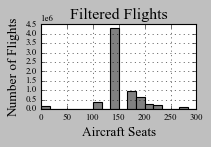

In [10]:
get_dropped = False

title_name = 'Dropped Flights' if get_dropped else 'Filtered Flights'
filename_append = 'dropped' if get_dropped else 'kept'

seat_df = pd.DataFrame(columns=['Destination_Airport_Code','Origin_Airport_Code','Seat_Num'])

for airline in airline_list:
    for year in year_range:
        df = pd.read_csv('%s%s_%s_route_seats_%s.csv'%(processed_direc,airline,year,filename_append))

        seat_df = seat_df.append(df, ignore_index=True)

seat_df = seat_df.astype({'Seat_Num':'int64'})

bins = np.linspace(0,300,19)
pd.DataFrame.hist(data=seat_df,column='Seat_Num', color='gray', bins=bins, figsize=(2.8,2.0))

plt.ylim(top=4500000)
plt.title(title_name)
plt.xlabel('Aircraft Seats')
plt.ylabel('Number of Flights')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()

filename = graph_direc + title_name.lower().replace(' ','_') + '_seats.pdf'

plt.savefig(filename,dpi=300,transparent=True)
# plt.savefig('%sroute_seats_%s_hist.pdf'%(graph_direc,filename_append))

### Create Betweeness Centrality Data
Calculate the betweeness for each node (airport) based on route loading.

In [6]:
db_path = '%s/data/processed/atn_db.sqlite' %(dir_path,)
year_list = [2015,2016,2017]
airline_list = ['AA','DL','UA','WN']

df = pd.DataFrame(columns=year_list,index=airline_list)
for airline in airline_list:
        for year in year_list:
                between_stat = atn_tools.calculate_betweenness_centrality(year,airline)
                df.at[airline,year] = sum(between_stat.values())/len(between_stat.values())
df['Airline'] = df.index                
df.to_csv(processed_direc + 'betweenness_centrality.csv', index=False)

In [16]:
db_path = '%s/data/processed/atn_db.sqlite' %(dir_path,)
year_list = [2015,2016,2017]
airline_list = ['AA','DL','UA','WN']

for airline in airline_list:
        data_list = []
        for year in year_list:
                between_stat = atn_tools.calculate_betweenness_centrality(year,airline)
                betweeness_avg = sum(between_stat.values())/len(between_stat.values())
                data_list.append([airline,year,betweeness_avg])

        df = pd.DataFrame(data_list,columns=['Airline','Year','Betweeness'])       
        df.to_csv(processed_direc + '%s_betweenness_centrality.csv'%airline, index=False)

### Create Graph of Between Centrality Data

Line2D(Airline)
Line2D(AA)
Line2D(DL)
Line2D(UA)
Line2D(WN)


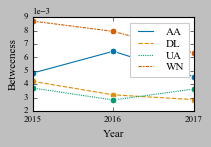

In [38]:
between_df = pd.read_csv(processed_direc + 'betweenness_centrality.csv')
between_df['Year'] = between_df['Year'].apply(lambda x: pd.to_datetime(x,format='%Y'))

fig, ax = plt.subplots(figsize=(2.8,2.0))
# fig, ax = plt.subplots(figsize=(5.5,2.5))
sns.lineplot(data=between_df, ax=ax, x='Year',y='Betweeness',hue='Airline',style='Airline',marker = 'o')   

# Remove legend titles
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
    print(handle)
ax.legend(loc = 'upper right', handles=handles[1:], labels=labels[1:],labelspacing=0.15,scatterpoints=1)

ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Betweeness',fontsize=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# # Remove legend titles
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(loc = 'upper right', handles=handles[1:], labels=labels[1:],labelspacing=0.15)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('0.8')
fig.tight_layout()

plt.savefig(graph_direc + 'betweeness_centrality_plot.pdf',dpi = 300,transparent=True)


    # ax.set_xlabel('',fontsize=10)
    # ax.set_ylabel('Mahalabonis distance',fontsize=10)
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    # ax.legend(loc = 'upper left',fontsize=10)
    # ax.xaxis.set_tick_params(labelsize=8)
    # ax.yaxis.set_tick_params(labelsize=8)

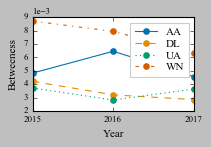

In [43]:
# plt.figure(1,figsize=(2.8,2.0),dpi=300)
fig, ax = plt.subplots(figsize=(2.8,2.0))
# fig, ax = plt.subplots(figsize=(5.5,2.5))
# sns.lineplot(data=between_df, ax=ax, x='Year',y='Betweeness',hue='Airline',style='Airline',marker = 'o')   
line_type_iter = 1
for airline in airline_list:
    between_df = pd.read_csv(processed_direc + '%s_betweenness_centrality.csv'%airline)
    between_df['Year'] = between_df['Year'].apply(lambda x: pd.to_datetime(x,format='%Y'))
    plt.plot(between_df['Year'],between_df['Betweeness'], label="{}".format(airline),linestyle=line_type[line_type_iter], marker = 'o',markeredgecolor='None')
    # plt.xticks(year_list)
    plt.xlabel('Year',fontsize=10)
    plt.ylabel('Betweeness',fontsize=10)
    plt.legend(numpoints=1)

    line_type_iter+=1

# Remove legend titles
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(loc = 'upper right', handles=handles[1:], labels=labels[1:],labelspacing=0.15)
ax.legend(airline_list,numpoints=1)

# ax.set_xlabel('Year', fontsize=10)

ax.set_ylabel('Betweeness',fontsize=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# # Remove legend titles
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(loc = 'upper right', handles=handles[1:], labels=labels[1:],labelspacing=0.15)

# leg = plt.legend()
# leg.get_frame().set_edgecolor('0.8')
fig.tight_layout()

plt.savefig(graph_direc + 'betweeness_centrality_plot.pdf',dpi = 300,transparent=True)

## Create Distribution Plot of Edge Weights
Based on this method: https://github.com/mwaskom/seaborn/issues/861#issuecomment-455777105

/Users/allen/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


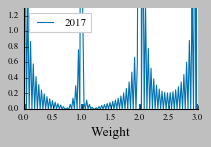

In [22]:
# airline_list = ['AA','DL','UA','WN']
airline_list = ['UA']
year_range=[2017]
# weight_df = pd.DataFrame(columns=['Year','Airline','Weight'])
for airline in airline_list:
    weight_df = pd.DataFrame(columns=['Airline','Year','Weight'])
    for year in year_range:
        data_df = pd.read_csv('%s%s_%s_edge_weights.csv'%(processed_direc,airline,year))
        data_df['Year'] = year
        data_df['Airline'] = airline
        weight_df = weight_df.append(data_df)

    bins = [0,1,2,3]
    g = sns.FacetGrid(weight_df, hue="Year", height=2.0, aspect=1.4)
    g = g.map(sns.distplot, "Weight", hist=False, bins=bins, rug=True)
    
    filepath = '%s%s_%s_weight_distribution.pdf'%(graph_direc,airline,year)
    plt.ylim(top=1.3)
    plt.tick_params(top=False,right=False)
    plt.legend(loc='upper left')

    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, transparent=True)


## Create Distribution Plot of Edge Load (flight number)

In [14]:
db_queries = db_tools.DBQueries()
# airline_list = ['AA']
sql = ''' 
    SELECT Destination_Airport_Code AS Destination, Origin_Airport_Code AS Origin
    FROM atn_performance
    WHERE Destination_Airport_Code IN (
        SELECT Destination_Airport_Code
        FROM atn_performance
        WHERE Year = :year
        AND Unique_Carrier_ID LIKE :airline
        AND Can_Status != 1 AND Div_Status != 1 
        GROUP BY Destination_Airport_Code
        HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
        )
    AND Year = :year
    AND Unique_Carrier_ID LIKE :airline
    AND Can_Status != 1 AND Div_Status != 1 
    '''
for airline in airline_list:
    query_airline = airline
    if airline=='ALL' or airline=='':
        query_airline = '%'

    weight_df = pd.DataFrame(columns=['Airline','Year','Weight'])
    for year in year_range:
        days_in_year = 366 if calendar.isleap(year) else 365
            
        airline_df = db_queries.query_to_df(sql,params={'year' : year, 'days_in_year' : days_in_year,'airline' : query_airline})

        # Get the occurences of each unique edge/route and weight the values
        edge_df = airline_df.groupby(['Origin','Destination']).size().reset_index(name='Count')
        edge_df['Weight'] = edge_df['Count'].apply(np.log10)
        # edge_df['Weight'] = edge_df['Weight'].apply(lambda x: (x - edge_df['Weight'].min())/(edge_df['Weight'].max()-edge_df['Weight'].min()))
        # edge_df['Weight'] = min_max_scaler.fit_transform(edge_df['Weight_Unscaled'])

        edge_df['Year'] = year
        weight_df = weight_df.append(edge_df[['Year','Weight']],sort=False)
    g = sns.FacetGrid(weight_df, hue="Year", height=2.0, aspect=1.4)

    hue_kws={"kde_kws":[{"linestyle":'-'},{"linestyle":'--'},{"linestyle":':'},{"linestyle":'-.'}]}
    # g = sns.FacetGrid(weight_df, hue="Year", height=2.0, aspect=1.4,hue_kws={"linestyle":['-','--',':','-.']})
    g = sns.FacetGrid(weight_df, hue="Year", height=2.0, aspect=1.4,hue_kws=hue_kwd)
    g = g.map(sns.distplot, "Weight", hist=False)
    [line.set_linestyle("--") for line in g.lines]
    # g = g.map(plt.hist, "Weight")
    # for ax in g.axes.flat:
    #     print (ax.lines)
    #     for line in ax.lines:
    #         print (line.get_xdata())
    #         print (line.get_ydata())
    # line = g.get_lines()[0]
    # xd = line.get_xdata()
    # yd = line.get_ydata()

    # y_norm = (yd - yd.min(0)) / yd.ptp(0)
    # ax2.plot(xd, yd2)
    
    plt.xlabel("Edge Weight")
    plt.ylabel("Probability")
    plt.xscale('log')
    plt.ylim(top=1.3)
    plt.xlim((0.1,5.0))
    plt.xticks([0.1,1,2,3,4,5],[0.1,1,2,3,4,5])
    plt.tick_params(top=False,right=False)
    plt.legend(loc='upper left')
    sns.despine(top=False,right=False)

    
    plt.tight_layout()
    filepath = '%s%s_weight_distribution.pdf'%(graph_direc,airline)
    plt.savefig(filepath, dpi=300, transparent=True)

NameError: name 'hue_kwd' is not defined

/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/allen/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

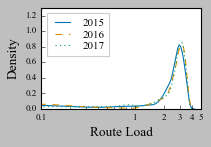

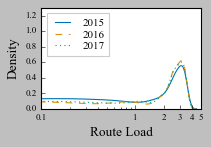

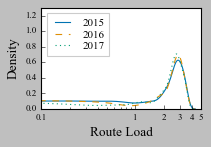

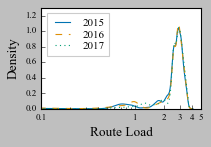

In [4]:
db_queries = db_tools.DBQueries()

sql = ''' 
    SELECT Destination_Airport_Code AS Destination, Origin_Airport_Code AS Origin
    FROM atn_performance
    WHERE Destination_Airport_Code IN (
        SELECT Destination_Airport_Code
        FROM atn_performance
        WHERE Year = :year
        AND Unique_Carrier_ID LIKE :airline
        AND Can_Status != 1 AND Div_Status != 1 
        GROUP BY Destination_Airport_Code
        HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
        )
    AND Year = :year
    AND Unique_Carrier_ID LIKE :airline
    AND Can_Status != 1 AND Div_Status != 1 
    '''
for airline in airline_list:
    query_airline = airline
    if airline=='ALL' or airline=='':
        query_airline = '%'

    weight_df = pd.DataFrame(columns=['Airline','Year','Weight'])
    counter = 1

    fig, ax = plt.subplots(figsize=(2.8,2.0))
    for year in year_range:
        days_in_year = 366 if calendar.isleap(year) else 365
            
        airline_df = db_queries.query_to_df(sql,params={'year' : year, 'days_in_year' : days_in_year,'airline' : query_airline})

        # Get the occurences of each unique edge/route and weight the values
        edge_df = airline_df.groupby(['Origin','Destination']).size().reset_index(name='Count')
        edge_df['Weight'] = edge_df['Count'].apply(np.log10)

        edge_df['Year'] = year
        weight_df = weight_df.append(edge_df[['Year','Weight']],sort=False)

        sns.distplot(edge_df['Weight'], hist=False, label=year, kde_kws={'linestyle':line_type[counter]})
        plt.legend(loc='upper left')
        handles, labels = ax.get_legend_handles_labels()
        counter += 1
    ax.set_xlabel("Route Load")
    ax.set_ylabel("Density")
    plt.tick_params(top=False,right=False)
    ax.xaxis.set_ticks_position('bottom')
    plt.xscale('log')
    plt.ylim(top=1.3)
    plt.xlim((0.1,5.0))
    plt.xticks([0.1,1,2,3,4,5],[0.1,1,2,3,4,5])

    line = ax.lines[0]
    # print(line.get_ydata())

    plt.tight_layout()
    filepath = '%s%s_weight_distribution.pdf'%(graph_direc,airline)
    plt.savefig(filepath, dpi=300, transparent=True)

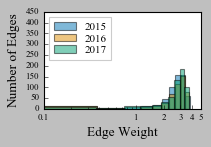

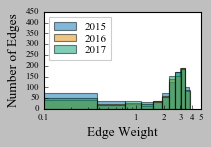

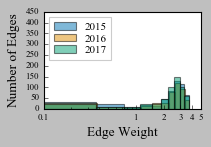

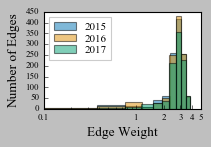

In [6]:
db_queries = db_tools.DBQueries()

sql = ''' 
    SELECT Destination_Airport_Code AS Destination, Origin_Airport_Code AS Origin
    FROM atn_performance
    WHERE Destination_Airport_Code IN (
        SELECT Destination_Airport_Code
        FROM atn_performance
        WHERE Year = :year
        AND Unique_Carrier_ID LIKE :airline
        AND Can_Status != 1 AND Div_Status != 1 
        GROUP BY Destination_Airport_Code
        HAVING COUNT(DISTINCT(Day_Of_Year)) = :days_in_year
        )
    AND Year = :year
    AND Unique_Carrier_ID LIKE :airline
    AND Can_Status != 1 AND Div_Status != 1 
    '''
for airline in airline_list:
    query_airline = airline
    if airline=='ALL' or airline=='':
        query_airline = '%'

    weight_df = pd.DataFrame(columns=['Airline','Year','Weight'])
    counter = 1

    fig, ax = plt.subplots(figsize=(2.8,2.0))
    for year in year_range:
        days_in_year = 366 if calendar.isleap(year) else 365
            
        airline_df = db_queries.query_to_df(sql,params={'year' : year, 'days_in_year' : days_in_year,'airline' : query_airline})

        # Get the occurences of each unique edge/route and weight the values
        edge_df = airline_df.groupby(['Origin','Destination']).size().reset_index(name='Count')
        edge_df['Weight'] = edge_df['Count'].apply(np.log10)

        edge_df['Year'] = year
        weight_df = weight_df.append(edge_df[['Year','Weight']],sort=False)

        # sns.distplot(edge_df['Weight'], kde=False, label=year, kde_kws={'linestyle':line_type[counter]})
        edge_df.groupby('Year')['Weight'].plot.hist(alpha=0.5)
        plt.legend(loc='upper left')
        handles, labels = ax.get_legend_handles_labels()
        counter += 1
    ax.set_xlabel("Edge Weight")
    ax.set_ylabel("Number of Edges")
    plt.tick_params(top=False,right=False)
    ax.xaxis.set_ticks_position('bottom')
    plt.xscale('log')
    plt.ylim(top=450)
    plt.xlim((0.1,5.0))
    plt.xticks([0.1,1,2,3,4,5],[0.1,1,2,3,4,5])

    # line = ax.lines[0]
    # print(line.get_ydata())

    plt.tight_layout()
    filepath = '%s%s_weight_hist.pdf'%(graph_direc,airline)
    plt.savefig(filepath, dpi=300, transparent=True)

In [9]:
print(edge_df)
edge_df.to_csv('weights_df.csv')

Origin Destination  Count    Weight  Year
0      ABQ         DFW   1674  0.877795  2017
1      ABQ         ORD    125  0.570967  2017
2      ABQ         PHX      9  0.259830  2017
3      ALB         CLT   1018  0.818979  2017
4      AMA         DFW    213  0.633994  2017
5      ANC         DFW    123  0.569060  2017
6      ANC         LAX     80  0.518192  2017
7      ANC         PHX     81  0.519661  2017
8      ATL         CLT   2286  0.914642  2017
9      ATL         DFW   2572  0.928582  2017
10     ATL         LAX   1009  0.817928  2017
11     ATL         ORD    926  0.807777  2017
12     ATL         PHL   1956  0.896206  2017
13     ATL         PHX    736  0.780621  2017
14     AUS         CLT   1393  0.856065  2017
15     AUS         DFW   3818  0.975297  2017
16     AUS         LAX   1115  0.829741  2017
17     AUS         ORD   1210  0.839411  2017
18     AUS         PHL    600  0.756462  2017
19     AUS         PHX    644  0.764831  2017
20     BDL         CLT   1952  0.89596

## Get the Table of Highest Airport Removals

In [17]:
airline = 'AA'
year = 2015
can_limit = 0.1
zs_limit = 0.95

pivot_dict = {}

removal_dict = atn_tools.remove_frequency(db_path, 2015, airline, include_data, can_limit, zs_limit, processed_direc)

pivot_dict['Airport'] = list(removal_dict.keys())
pivot_dict['Weight'] = [int(removal_dict[airport]) for airport in pivot_dict['Airport']]
# list(removal_dict.values())

removal_df = pd.DataFrame.from_dict(pivot_dict)
removal_df.sort_values(by=['Weight'],ascending=False,inplace=True)
print(removal_df.head(n=15))

Airport  Weight
28     DEN     190
2      DFW     132
36     TUS     100
9      LAS      84
23     SEA      68
7      MIA      62
52     LIH      60
63     ABQ      59
45     BWI      55
14     IAD      49
17     PHL      40
25     SJC      39
64     ELP      38
11     DCA      38
4      OGG      38


In [14]:
# print(pivot_dict)
removal_dict['IAD']

49